In [5]:
# import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys

import keras

# Projet autoencoder as asymetric encryption

## Evaluation metric

### All evaluation are between 2 image size 24*24 in jpeg format 

In [6]:
def add_gaussian_noise(image, mean=0.0, stddev=0.1, clip_range=(0, 1)):
    """
    Add Gaussian noise to an image.

    Parameters:
        image (numpy array): Input image with pixel values in the range [0, 1].
        mean (float): Mean of the Gaussian noise.
        stddev (float): Standard deviation of the Gaussian noise.
        clip_range (tuple): Minimum and maximum values to clip the noisy image.

    Returns:
        noisy_image (numpy array): Image with added Gaussian noise.
    """
    # Generate Gaussian noise
    noise = np.random.normal(loc=mean, scale=stddev, size=image.shape)

    # Add noise to the image
    noisy_image = image + noise

    # Clip the pixel values to stay within the valid range
    noisy_image = np.clip(noisy_image, clip_range[0], clip_range[1])

    return noisy_image


### Entropy

In [7]:
import numpy as np

def calculate_entropy2(encoded_data):
    # Flatten the encoded data to a 1D array
    flattened_data = encoded_data.flatten()
    
    # Compute the histogram
    hist, _ = np.histogram(flattened_data, bins=256, density=True)
    
    # Filter out zero probabilities for entropy calculation
    hist = hist[hist > 0]
    
    # Calculate entropy
    entropy = -np.sum(hist * np.log2(hist))
    
    return entropy

## Cosine similarity

In [8]:
def cosine_similarity(img1,img2):
    # calculate the cosine similarity between the original image and the perturbed image
    # img1: original image
    # img2: perturbed image
    # return: cosine similarity value
    img1 = img1.flatten()
    img2 = img2.flatten()
    # calculate the cosine similarity
    similarity = np.dot(img1, img2) / (np.linalg.norm(img1) * np.linalg.norm(img2))
    return similarity

### MSE

In [9]:
def calculate_MSE(img1,img2):
    # calculate the mean square error between the original image and the decryted image
    # img1: original image
    # img2: decrypted image
    # return: MSE value
    img1 = img1.flatten()
    img2 = img2.flatten()
    return np.mean((img1 - img2) ** 2)

### Kendall and Spearman Correlations: 


In [10]:
from scipy.stats import kendalltau, pearsonr, spearmanr

In [11]:
def calculate_pixel_correlation(image):
    # Convertir en niveaux de gris si nécessaire
    if image.shape[-1] == 3:  # Si image RGB
        image = np.mean(image, axis=-1)  # Conversion en niveaux de gris

    # Extraire les pixels adjacents (horizontalement)
    x = image[:, :-1].flatten()  # Pixels de gauche
    y = image[:, 1:].flatten()  # Pixels de droite

    # Calculer les corrélations
    kendall_corr, _ = kendalltau(x, y)
    spearman_corr, _ = spearmanr(x, y)

    return kendall_corr, spearman_corr

## Algorithme comparaison

We will compare to chacha2, AES_HMAC-SHA256, two-fish for sysmetric encryption and RSA, ECC for asymetric encryption

In [12]:
from Crypto.Cipher import ChaCha20
from Crypto.Random import get_random_bytes
from Crypto.Cipher import AES
from Crypto.Random import get_random_bytes
from Crypto.Hash import HMAC, SHA256
from Crypto.Cipher import AES
from Crypto.Util.Padding import unpad
import numpy as np

# chacha2
def chacha20_encrypt(image, key):
    """
    Encrypts a 24x24x3 image using ChaCha20.

    :param image: NumPy array of shape (24, 24, 3)
    :param key: ChaCha20 key (32 bytes)
    :return: ciphertext (bytes), nonce (bytes)
    """
    image_flat = image.astype(np.uint8).flatten()  # Flatten the image
    cipher = ChaCha20.new(key=key)                 # Create ChaCha20 cipher
    ciphertext = cipher.encrypt(image_flat.tobytes())
    return ciphertext, cipher.nonce
    

def chacha20_decrypt(ciphertext, nonce, key):
    """
    Decrypts ChaCha20-encrypted image.

    :param ciphertext: The encrypted bytes
    :param nonce: Nonce used during encryption (bytes)
    :param key: ChaCha20 key (32 bytes)
    :return: Reconstructed NumPy array of shape (24, 24, 3)
    """
    cipher = ChaCha20.new(key=key, nonce=nonce)
    decrypted_bytes = cipher.decrypt(ciphertext)
    decrypted_array = np.frombuffer(decrypted_bytes, dtype=np.uint8)  # Convert bytes to array
    return decrypted_array.reshape((24, 24, 3))


from Crypto.Util.Padding import pad, unpad
from Crypto.Hash import HMAC, SHA256





In [13]:
from Crypto.Cipher import AES
from Crypto.Util.Padding import pad, unpad
from Crypto.Hash import HMAC, SHA256
import numpy as np

def aes_hmac_sha256_encrypt(img, key):
    """
    Encrypt the image using AES with HMAC-SHA256.

    Parameters:
        img (numpy array): Original image (numpy array).
        key (bytes): Encryption key (32 bytes).

    Returns:
        tuple: Encrypted image as bytes, IV used for encryption.
    """
    image_flat = img.astype(np.uint8).flatten()
    
    # Create CBC cipher
    cipher = AES.new(key, AES.MODE_CBC)
    
    # Pad the image data to make its length a multiple of AES.block_size
    padded_image = pad(image_flat.tobytes(), AES.block_size)
    
    # Encrypt the padded image
    ciphertext = cipher.encrypt(padded_image)
    
    return ciphertext, cipher.iv


def aes_hmac_sha256_decrypt(ciphertext, iv, key):
    """
    Decrypt the image and validate HMAC.

    Parameters:
        ciphertext (bytes): Encrypted image as bytes.
        iv (bytes): IV used for encryption.
        key (bytes): Decryption key (32 bytes).

    Returns:
        numpy array: Decrypted image as numpy array with its original shape.
    """
    cipher = AES.new(key, AES.MODE_CBC, iv)
    
    # Decrypt the ciphertext and remove the padding
    decrypted_bytes = unpad(cipher.decrypt(ciphertext), AES.block_size)
    
    # Convert bytes to numpy array
    decrypted_array = np.frombuffer(decrypted_bytes, dtype=np.uint8)
    
    return decrypted_array.reshape((24, 24, 3))

In [14]:
from twofish import Twofish

def two_fish_encrypt(image, key):
    """
    Encrypts a 24x24x3 image using Twofish.

    :param image: NumPy array of shape (24, 24, 3)
    :param key: Twofish key (16, 24, or 32 bytes)
    :return: Encrypted image (bytes)
    """
    image_flat = image.astype(np.uint8).flatten()  # Flatten the image
    tf = Twofish(key)  # Create Twofish cipher
    encrypted_image = b""
    block_size = 16  # Twofish block size is 16 bytes
    for i in range(0, len(image_flat), block_size):
        block = image_flat[i:i + block_size]
        if len(block) < block_size:
            block = np.pad(block, (0, block_size - len(block)), 'constant')
        encrypted_image += tf.encrypt(block.tobytes())
    return encrypted_image

def two_fish_decrypt(encrypted_image, key, original_shape=(24, 24, 3)):
    """
    Decrypts a Twofish-encrypted image.

    :param encrypted_image: The encrypted bytes
    :param key: Twofish key (16, 24, or 32 bytes)
    :param original_shape: Shape of the original image
    :return: Decrypted image as NumPy array with its original shape
    """
    tf = Twofish(key)  # Create Twofish cipher
    decrypted_image = b""
    block_size = 16  # Twofish block size is 16 bytes
    for i in range(0, len(encrypted_image), block_size):
        block = encrypted_image[i:i + block_size]
        decrypted_image += tf.decrypt(block)
    decrypted_array = np.frombuffer(decrypted_image, dtype=np.uint8)
    return decrypted_array[:np.prod(original_shape)].reshape(original_shape)

In [15]:
from Crypto.PublicKey import RSA
from Crypto.Cipher import PKCS1_OAEP
from Crypto.Random import get_random_bytes

def generate_rsa_keypair(key_size=2048):
    """
    Generate an RSA key pair.

    :param key_size: Size of the RSA key in bits.
    :return: RSA key pair (private_key, public_key)
    """
    key = RSA.generate(key_size)
    private_key = key.export_key()
    public_key = key.publickey().export_key()
    return private_key, public_key

def rsa_encrypt(image, public_key):
    """
    Encrypt a 24x24x3 image using RSA.

    :param image: NumPy array of shape (24, 24, 3)
    :param public_key: RSA public key (bytes)
    :return: Encrypted image (bytes)
    """
    image_flat = image.astype(np.uint8).flatten()  # Flatten the image
    rsa_key = RSA.import_key(public_key)
    cipher = PKCS1_OAEP.new(rsa_key)
    encrypted_image = b""
    chunk_size = rsa_key.size_in_bytes() - 42  # PKCS1_OAEP padding overhead
    for i in range(0, len(image_flat), chunk_size):
        chunk = image_flat[i:i + chunk_size].tobytes()  # Convert chunk to bytes
        encrypted_image += cipher.encrypt(chunk)
    return encrypted_image
def rsa_decrypt(encrypted_image, private_key, original_shape=(24, 24, 3)):
    """
    Decrypt an RSA-encrypted image.

    :param encrypted_image: The encrypted bytes
    :param private_key: RSA private key (bytes)
    :param original_shape: Shape of the original image
    :return: Decrypted image as NumPy array with its original shape
    """
    rsa_key = RSA.import_key(private_key)
    cipher = PKCS1_OAEP.new(rsa_key)
    decrypted_image = b""
    chunk_size = rsa_key.size_in_bytes()
    for i in range(0, len(encrypted_image), chunk_size):
        chunk = encrypted_image[i:i + chunk_size]
        decrypted_image += cipher.decrypt(chunk)
    decrypted_array = np.frombuffer(decrypted_image, dtype=np.uint8)
    return decrypted_array.reshape(original_shape)

## Part 1: Autoencoder/decoder

In [16]:
from tensorflow import keras
from keras import layers, regularizers

def build_encoder(input_shape=(24, 24, 3), latent_dim=32):
    input_img = layers.Input(shape=input_shape)

    # Conv2D layer with L2 regularization
    x = layers.Conv2D(32, (3, 3), padding='same', activation='relu',
                      kernel_regularizer=regularizers.l2(0.01))(input_img)
    x = layers.MaxPooling2D((2, 2))(x)  # Downsample*
    # batch normalization
    x = layers.BatchNormalization()(x)

    x = layers.Conv2D(64, (3, 3), padding='same', activation='relu',
                      kernel_regularizer=regularizers.l2(0.01))(x)
    x = layers.MaxPooling2D((2, 2))(x)  # Downsample
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)  # Regularization


    x = layers.Conv2D(64, (3, 3), padding='same', activation='relu',
                      kernel_regularizer=regularizers.l2(0.01))(x)
    x = layers.MaxPooling2D((2, 2))(x)  # Downsample
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)  # Regularization

    # Flatten and map to latent space
    shape_before_flattening = keras.backend.int_shape(x)
    x = layers.Flatten()(x)
    latent = layers.Dense(latent_dim)(x)

    # Create encoder model
    encoder = keras.models.Model(input_img, latent)
    return encoder, shape_before_flattening


In [17]:
def build_decoder(shape_before_flattening, latent_dim=32):
    latent_inputs = layers.Input(shape=(latent_dim,))

    # Map latent space back to original shape
    x = layers.Dense(np.prod(shape_before_flattening[1:]), activation='relu')(latent_inputs)
    x = layers.Reshape(shape_before_flattening[1:])(x)

    # Conv2DTranspose layer to upsample
    x = layers.Conv2D(64, (3, 3), padding='same', activation='relu',
                      kernel_regularizer=regularizers.l2(0.01))(x)
    x = layers.UpSampling2D((2, 2))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)

    x = layers.Conv2D(64, (3, 3), padding='same', activation='relu',
                      kernel_regularizer=regularizers.l2(0.01))(x)
    x = layers.UpSampling2D((2, 2))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)

    x = layers.Conv2D(32, (3, 3), padding='same', activation='relu',
                      kernel_regularizer=regularizers.l2(0.01))(x)
    x = layers.UpSampling2D((2, 2))(x)

    # Final Conv2D layer with sigmoid activation to produce output in [0, 1]
    output_img = layers.Conv2D(3, (3, 3), padding='same', activation='sigmoid')(x)

    # Create decoder model
    decoder = keras.models.Model(latent_inputs, output_img)
    return decoder


In [18]:
def build_autoencoder(encoder, decoder):
    # build the autoencoder model
    # encoder: the encoder model
    # decoder: the decoder model
    # return: the autoencoder model
    autoencoder = keras.models.Model(encoder.input, decoder(encoder(encoder.input)))
    return autoencoder

In [19]:
def add_gaussian_noise(image, mean=0.0, stddev=0.1, clip_range=(0, 1)):
    """
    Add Gaussian noise to an image.

    Parameters:
        image (numpy array): Input image with pixel values in the range [0, 1].
        mean (float): Mean of the Gaussian noise.
        stddev (float): Standard deviation of the Gaussian noise.
        clip_range (tuple): Minimum and maximum values to clip the noisy image.

    Returns:
        noisy_image (numpy array): Image with added Gaussian noise.
    """
    # Generate Gaussian noise
    noise = np.random.normal(loc=mean, scale=stddev, size=image.shape)

    # Add noise to the image
    noisy_image = image + noise

    # Clip the pixel values to stay within the valid range
    noisy_image = np.clip(noisy_image, clip_range[0], clip_range[1])

    return noisy_image


## DATASET

In [20]:

print('TensorFlow version:', keras.__version__)

TensorFlow version: 2.10.0


In [21]:
# dataset_path = r"C:\Users\enzoh\Downloads\downsampled-open-images-v4\512px\train-512\512"
# # Load the 350000 first images from the dataset and resize them to 24x24
# max_images = 350000
# total_images = len(os.listdir(dataset_path))
# print(f"Total images: {total_images}")
# # rename all images to numbers but start with i = 142071
# for i, filename in enumerate(os.listdir(dataset_path),start=142071):
#     os.rename(os.path.join(dataset_path, filename), os.path.join(dataset_path, f"{i}.jpg"))
  


# # for i in range(350000):
# #     img = keras.preprocessing.image.load_img(os.path.join(dataset_path, f"{i}.jpg"), target_size=(24, 24), color_mode='color')
# #     img = keras.preprocessing.image.img_to_array(img)
# #     images.append(img)

In [22]:
import os
import numpy as np
import cv2  # OpenCV for fast image loading

# Paths and parameters
dataset_path = r"C:\Users\enzoh\Downloads\downsampled-open-images-v4\512px\train-24\512"  # change your path Here
total_images = 500000  # Number of images to load # adapt this number to your needs and with your hardware limitations
img_shape = (24, 24, 3)  # Target size (RGB, 3 channels)

# Preallocate a NumPy array for all images (float32 for normalized values) to save memory and have a faster loading ( from 40 minutes to arround 5 minutes)
all_images = np.zeros((total_images, *img_shape), dtype=np.float32)

# Load and store images directly into the preallocated array
for i, filename in enumerate(os.listdir(dataset_path)):
    if i >= total_images:
        break

    img_path = os.path.join(dataset_path, filename)

    try:
        # Load the image as RGB using OpenCV
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)  # Loads in BGR format

        # Resize to (24, 24) if necessary
        if img.shape[:2] != img_shape[:2]:
            img = cv2.resize(img, img_shape[:2])

        # Convert BGR to RGB (OpenCV loads as BGR by default)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Store the image in the preallocated array and normalize pixel values
        all_images[i] = img / 255.0  # Normalize to [0, 1] range

        # Print progress every 10,000 images
        if (i + 1) % 10000 == 0:
            print(f"Loaded {i + 1} images...")

    except Exception as e:
        print(f"Error loading {filename}: {e}")

print(f"Loaded {all_images.shape[0]} images with shape {all_images.shape[1:]} each.")


Loaded 10000 images...
Loaded 20000 images...
Loaded 30000 images...
Loaded 40000 images...
Loaded 50000 images...
Loaded 60000 images...
Loaded 70000 images...
Loaded 80000 images...
Loaded 90000 images...
Loaded 100000 images...
Loaded 110000 images...
Loaded 120000 images...
Loaded 130000 images...
Loaded 140000 images...
Loaded 150000 images...
Loaded 160000 images...
Loaded 170000 images...
Loaded 180000 images...
Loaded 190000 images...
Loaded 200000 images...
Loaded 210000 images...
Loaded 220000 images...
Loaded 230000 images...
Loaded 240000 images...
Loaded 250000 images...
Loaded 260000 images...
Loaded 270000 images...
Loaded 280000 images...
Loaded 290000 images...
Loaded 300000 images...
Loaded 310000 images...
Loaded 320000 images...
Loaded 330000 images...
Loaded 340000 images...
Loaded 350000 images...
Loaded 360000 images...
Loaded 370000 images...
Loaded 380000 images...
Loaded 390000 images...
Loaded 400000 images...
Loaded 410000 images...
Loaded 420000 images...
L

## Training

In [23]:
# print shape of the all images
print(all_images.shape)


(500000, 24, 24, 3)


Training images: (280000, 24, 24, 3)
Validation images: (70000, 24, 24, 3)
Min pixel value: 0.0
Max pixel value: 1.0
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 24, 24, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 24, 24, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 12, 12, 32)       0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 12, 12, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 12, 12, 64)        18496     
          

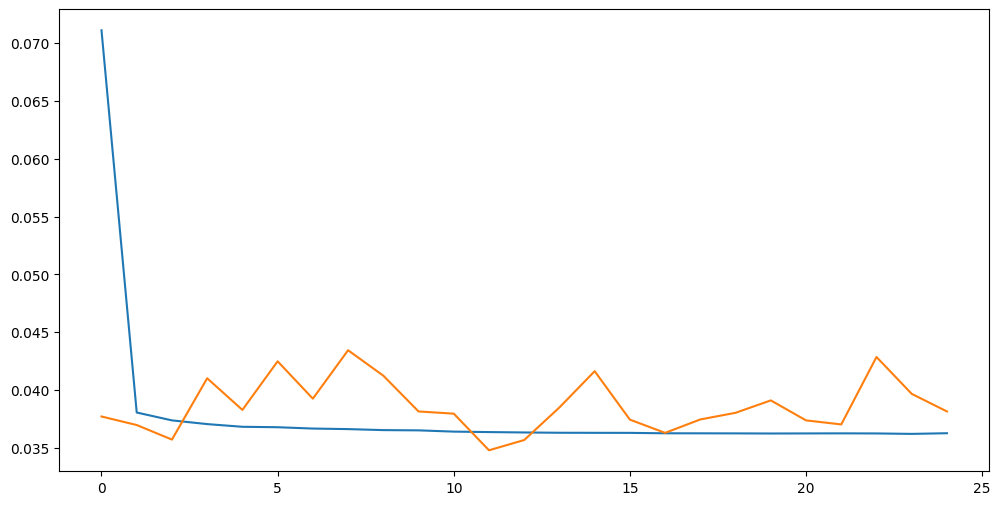

In [ ]:
# Split the images into training and validation sets but only use 400000 images istead of 500000
total_img = 350000
train_size = int(0.8 * total_img)
val_size = total_img - train_size
train_images = all_images[:train_size]
val_images = all_images[train_size:total_img]

print(f"Training images: {train_images.shape}")
print(f"Validation images: {val_images.shape}")

#check if the image are normalized
print(f"Min pixel value: {np.min(all_images)}")
print(f"Max pixel value: {np.max(all_images)}")

# Build the encoder
encoder, shape_before_flattening = build_encoder(input_shape=(24, 24, 3), latent_dim=32)
encoder.summary()

# Build the decoder
decoder = build_decoder(shape_before_flattening, latent_dim=32)
decoder.summary()

# Build the autoencoder
autoencoder = build_autoencoder(encoder, decoder)

# Compile the autoencoder
autoencoder.compile(optimizer='adam', loss='mse')
# add noise to the images
noisy_train_images = add_gaussian_noise(train_images, mean=0.0, stddev=0.3, clip_range=(0, 1))
noisy_val_images = add_gaussian_noise(val_images, mean=0.0, stddev=0.3, clip_range=(0, 1))

# Train the autoencoder with the noisy images
history = autoencoder.fit(noisy_train_images, train_images,
                            epochs=25,
                            batch_size=128,
                            shuffle=True,
                            validation_data=(noisy_val_images, val_images))
# Save the model
autoencoder.save('autoencoder_noisyonly.h5')

# Plot the training history
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')

In [25]:
def print_metrics(algorithms,original,decoded,encrypted,encryption_time,decryption_time):
    # Calculate the metrics
    mse = calculate_MSE(original, decoded)
    cosine_sim = cosine_similarity(original, decoded)
    entropy = calculate_entropy2(encrypted)
    kendall_corr, spearman_corr = calculate_pixel_correlation(encrypted)

    # Print the metrics
    print(f"Metrics for {algorithms}:")
    print(f"MSE: {mse:.4f}")
    print(f"Cosine Similarity: {cosine_sim:.4f}")
    print(f"Entropy: {entropy:.4f}")
    print(f"Kendall Correlation: {kendall_corr:.4f}")
    print(f"Spearman Correlation, {spearman_corr:.4f}")
    print(f"Encryption Time: {encryption_time:.4f} seconds")
    print(f"Decryption Time: {decryption_time:.4f} seconds")
    print("--------------------------------------------------")

In [72]:
import os

# Define the path to your dataset
dataset_path = r"C:\Users\enzoh\Downloads\downsampled-open-images-v4\512px\train-24\512"


# first rename all images to numbers but start with i = tmp x where x is the number of the image
# for i, filename in enumerate(os.listdir(dataset_path),0):
#     os.rename(os.path.join(dataset_path, filename), os.path.join(dataset_path,"tmp"+f"{i}.jpg"))


# rename all image in an incremental way from 0 to 499999 and check if name is already taken
for i, filename in enumerate(os.listdir(dataset_path),0):
    os.rename(os.path.join(dataset_path, filename), os.path.join(dataset_path, f"{i}.jpg"))

    

In [73]:
print(os.listdir(dataset_path)[:10])

['0.jpg', '1.jpg', '10.jpg', '100.jpg', '1000.jpg', '10000.jpg', '100000.jpg', '100001.jpg', '100002.jpg', '100003.jpg']


In [69]:
# look if the images are renamed 

import os

# Define the path to your dataset
dataset_path = r"C:\Users\enzoh\Downloads\downsampled-open-images-v4\512px\train-24\512"

# Check if  first  in rhe range 338210 338220 exist
for i in range(338210, 338220):
    if not os.path.exists(os.path.join(dataset_path, f"{i}.jpg")):
        print(f"File {i}.jpg not found.")


# print 500 first images name

import os

# Define the path to your dataset
dataset_path = r"C:\Users\enzoh\Downloads\downsampled-open-images-v4\512px\train-24\512"

# Print the first 500 image names
for i in range(10):
    print(os.path.join(dataset_path, f"{i}.jpg"))




File 338210.jpg not found.
File 338211.jpg not found.
File 338212.jpg not found.
File 338213.jpg not found.
File 338214.jpg not found.
File 338215.jpg not found.
File 338216.jpg not found.
File 338217.jpg not found.
File 338218.jpg not found.
File 338219.jpg not found.
C:\Users\enzoh\Downloads\downsampled-open-images-v4\512px\train-24\512\0.jpg
C:\Users\enzoh\Downloads\downsampled-open-images-v4\512px\train-24\512\1.jpg
C:\Users\enzoh\Downloads\downsampled-open-images-v4\512px\train-24\512\2.jpg
C:\Users\enzoh\Downloads\downsampled-open-images-v4\512px\train-24\512\3.jpg
C:\Users\enzoh\Downloads\downsampled-open-images-v4\512px\train-24\512\4.jpg
C:\Users\enzoh\Downloads\downsampled-open-images-v4\512px\train-24\512\5.jpg
C:\Users\enzoh\Downloads\downsampled-open-images-v4\512px\train-24\512\6.jpg
C:\Users\enzoh\Downloads\downsampled-open-images-v4\512px\train-24\512\7.jpg
C:\Users\enzoh\Downloads\downsampled-open-images-v4\512px\train-24\512\8.jpg
C:\Users\enzoh\Downloads\downsampled-

C:\Users\enzoh\Downloads\downsampled-open-images-v4\512px\train-24\512\280448.jpg
1/1 [==============================] - 0s 15ms/step
(1, 32)
1/1 [==============================] - 0s 17ms/step
Metrics for Autoencoder:
MSE: 0.0384
Cosine Similarity: 0.9505
Entropy: 12.3422
Kendall Correlation: 0.0581
Spearman Correlation, 0.1048
Encryption Time: 0.0389 seconds
Decryption Time: 0.0421 seconds
--------------------------------------------------
Metrics for ChaCha20:
MSE: 0.0000
Cosine Similarity: 1.0000
Entropy: 7.8981
Kendall Correlation: -0.0147
Spearman Correlation, -0.0209
Encryption Time: 0.0000 seconds
Decryption Time: 0.0000 seconds
--------------------------------------------------
Metrics for AES_HMAC_SHA256:
MSE: 0.0000
Cosine Similarity: 1.0000
Entropy: 7.9231
Kendall Correlation: -0.0024
Spearman Correlation, -0.0020
Encryption Time: 0.0000 seconds
Decryption Time: 0.0000 seconds
--------------------------------------------------
Metrics for TwoFish:
MSE: 0.0000
Cosine Similar

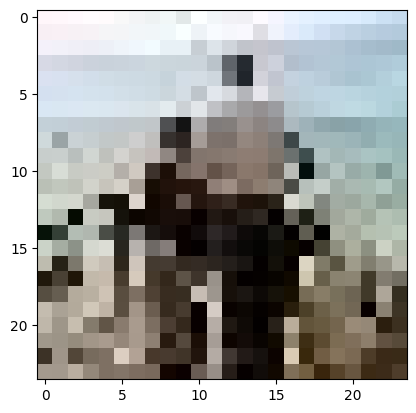

In [83]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import time
#test all metrics with the autoencoder
# Load the autoencoder model

# Select 20 images from the dataset

# you can use any image from the dataset that isn't used in the training set and preprocessed otherwise it will affect the results
# Todo : test on like 5000 and make a mean of the results 

#val index = 80% of 350000
val_index = 280000
val_len = 70000

random_image_index = np.random.randint(val_index, val_index + val_len)
img_path = os.path.join(dataset_path, f"{random_image_index}.jpg")

# take a random image from the validation set


# img_path = os.path.join(dataset_path, '100005.jpg')

# print the image path
print(img_path)

# Load the image
original_image = load_img(img_path, target_size=(24, 24), color_mode='rgb')
# display the image
plt.imshow(original_image)

#add noise to the image and preprocess it
original_image = img_to_array(original_image)
original_image_aes_ch20 = original_image  # Save a copy for AES and ChaCha20 because they work with uint8 
original_image = original_image / 255.0
original_image_saved = original_image

original_image.resize((1, 24, 24, 3))
original_shape = original_image.shape
noisy_image = add_gaussian_noise(original_image, mean=0.0, stddev=0.1, clip_range=(0, 1))
noisy_image_aes_ch20 = add_gaussian_noise(original_image_aes_ch20, mean=0.0, stddev=0.1, clip_range=(0, 255))
# Reshape the noisy image to have the correct dimensions

# Encode the noisy image
start = time.time()
encoded_image = encoder.predict(noisy_image)
original_image = noisy_image

encyrption_time = time.time() - start

# Show shape of the encoded image
print(encoded_image.shape)

# Decode the encoded image
start = time.time()
decoded_image = decoder.predict(encoded_image)
decrytion_time = time.time() - start



import numpy as np
from Crypto.Cipher import ChaCha20




############################################################################# AUtoendoder metrics############################################################################################################

# TEST for convulutional autoencoder
# Calculate entropy of the encrypted image


print_metrics("Autoencoder",original_image_saved,decoded_image,encoded_image,encyrption_time,decrytion_time)



########################################################################## CHACHA20 metrics ############################################################################################################

# TEST for chacha20

# same for cha cha 20
key = get_random_bytes(32)
# Encrypt the image
start = time.time()
encrypted_image, nonce = chacha20_encrypt(original_image_aes_ch20, key)
encryption_time = time.time() - start
start = time.time()
decrypted_image = chacha20_decrypt(encrypted_image, nonce, key).astype(np.uint8)
decryption_time = time.time() - start
array = np.frombuffer(encrypted_image, dtype=np.uint8)
encrypted_image_shaped = array[:np.prod(original_shape)].reshape(original_shape)

print_metrics("ChaCha20",original_image_aes_ch20,decrypted_image,encrypted_image_shaped,encryption_time,decryption_time)


############################################################################# AES_HMAC_SHA256 metrics ############################################################################################################


# same for AES_HMAC_SHA256
key = get_random_bytes(32)
# Encrypt the image
start = time.time()
encrypted_image,iv = aes_hmac_sha256_encrypt(original_image_aes_ch20, key)
array = np.frombuffer(encrypted_image, dtype=np.uint8)
encrypted_image_shaped = array[:np.prod(original_shape)].reshape(original_shape)
encryption_time = time.time() - start
# Decrypt the image
start = time.time()
decrypted_image = aes_hmac_sha256_decrypt(encrypted_image, iv, key)
decryption_time = time.time() - start

print_metrics("AES_HMAC_SHA256",original_image_aes_ch20,decrypted_image,encrypted_image_shaped,encryption_time,decryption_time)




############################################# TW0 FISH metrics ############################################################################################################


# same for two fish
key = get_random_bytes(32)
# Encrypt the image
start = time.time()
encrypted_image = two_fish_encrypt(original_image_aes_ch20, key)
encrypted_image_shaped = array[:np.prod(original_shape)].reshape(original_shape)
encryption_time = time.time() - start
# Decrypt the image
start = time.time()
decrypted_image = two_fish_decrypt(encrypted_image, key)
decryption_time = time.time() - start
# Calculate entropy of the encrypted image

print_metrics("TwoFish",original_image_aes_ch20,decrypted_image,encrypted_image_shaped,encryption_time,decryption_time)

########################################################## RSA metrics ############################################################################################################

# same for RSA
private_key, public_key = generate_rsa_keypair()
# Encrypt the image
start = time.time()
encrypted_image = rsa_encrypt(original_image_aes_ch20, public_key)
encryption_time = time.time() - start
# Decrypt the image
start = time.time()
decrypted_image = rsa_decrypt(encrypted_image, private_key)
decryption_time = time.time() - start
# Calculate entropy of the encrypted image
entropy_value = calculate_entropy2(encrypted_image_shaped)
mse = calculate_MSE(original_image_aes_ch20, decrypted_image)
kendal_corr, spearman_corr = calculate_pixel_correlation(encrypted_image_shaped)
cosine_sim_value = cosine_similarity(original_image_aes_ch20, decrypted_image)


print_metrics("RSA",original_image_aes_ch20,decrypted_image,encrypted_image_shaped,encryption_time,decryption_time)





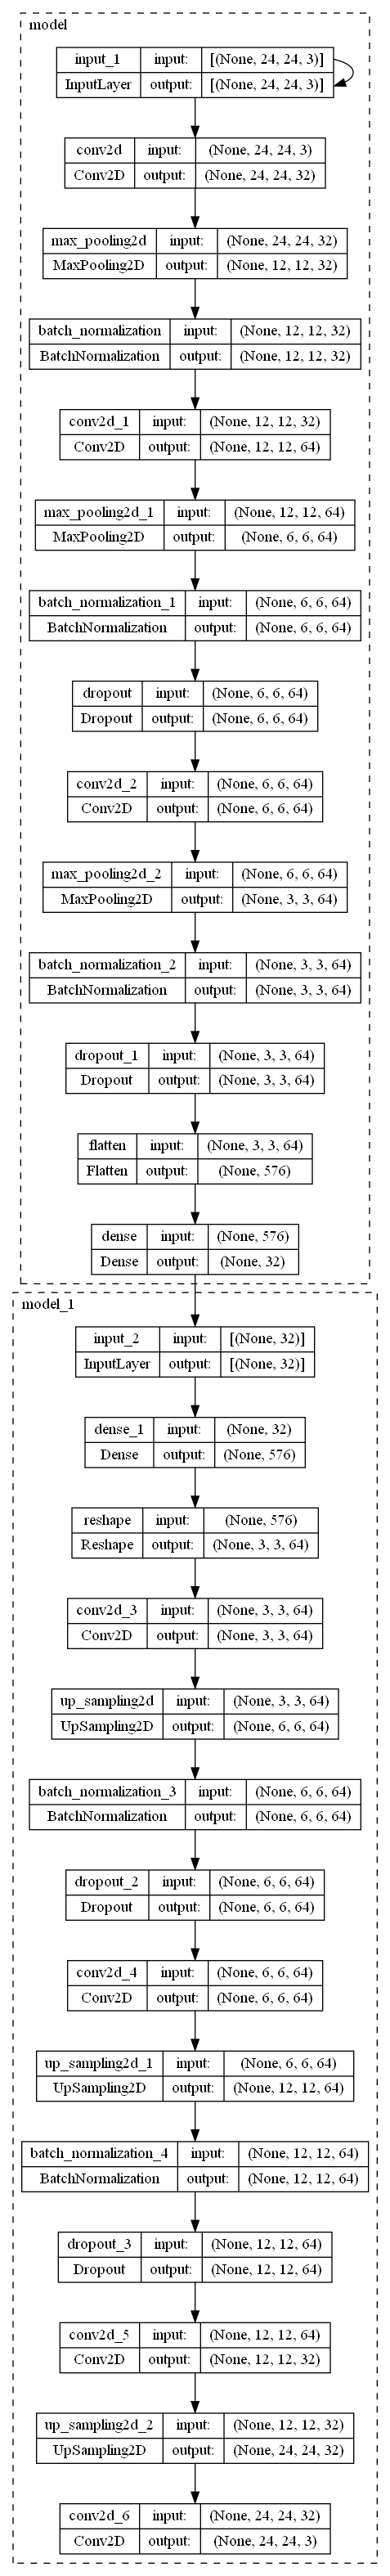

In [ ]:
# plot the autoencoder model with all layers of encoder and decoder
from tensorflow.keras.utils import plot_model

# Plot the autoencoder model
plot_model(autoencoder, show_shapes=True, show_layer_names=True, to_file='autoencoder.png',expand_nested=True)

# Plot the encoder model



## PAst codes 

This section only contains pass code that was wrong or not used anymore, i keep it for reference


In [ ]:
import numpy as np

def calculate_entropy(img1, img2):
    # Calculate the entropy of the original image and the perturbed image
    # img1: original image
    # img2: perturbed image
    # return: entropy difference (img2 - img1)

    # Flatten the images
    img1 = img1.flatten()
    img2 = img2.flatten()

    # Calculate the histogram of the original image
    hist1, _ = np.histogram(img1, bins=256, range=(0, 1))
    hist1 = hist1 / np.sum(hist1)  # Normalize the histogram

    # Calculate the histogram of the perturbed image
    hist2, _ = np.histogram(img2, bins=256, range=(0, 1))
    hist2 = hist2 / np.sum(hist2)  # Normalize the histogram

    # Calculate the entropy of the original image
    entropy1 = -np.sum(hist1 * np.log2(hist1 + 1e-7))

    # Calculate the entropy of the perturbed image
    entropy2 = -np.sum(hist2 * np.log2(hist2 + 1e-7))

    # Return the difference in entropy (perturbed - original)
    return entropy2 - entropy1

import numpy as np

def calculate_latent_entropy(latent_vector, bins=32):
    """Calculate the entropy of a latent space vector."""
    # Normalize the latent values to be between 0 and 1
    latent_vector = (latent_vector - np.min(latent_vector)) / (np.max(latent_vector) - np.min(latent_vector) + 1e-8)

    # Compute the histogram of the latent values
    histogram, _ = np.histogram(latent_vector, bins=bins, range=(0, 1), density=True)

    # Remove zero entries to avoid log(0) issues
    histogram = histogram[histogram > 0]

    # Calculate entropy using the information entropy formula
    entropy = -np.sum(histogram * np.log2(histogram))

    return entropy

def calculate_kendall_tau(img1,encryped_img):
    # calculate the kendall tau between the original image and the perturbed image
    # img1: original image
    # img2: perturbed image
    # return: kendall tau value
    img1 = img1.flatten()
    img2 = encryped_img.flatten()
    return kendalltau(img1, img2)[0]

def calculate_pearsonr(img1,encryped_img):
    # calculate the pearson correlation coefficient between the original image and the perturbed image
    # img1: original image
    # img2: perturbed image
    # return: pearson correlation coefficient value
    img1 = img1.flatten()
    img2 = encryped_img.flatten()
    return pearsonr(img1, img2)[0]

def calculate_spearmanr(img1,encryped_img):
    # calculate the spearman correlation
    # img1: original image
    # img2: perturbed image
    # return: spearman correlation coefficient value
    img1 = img1.flatten()
    img2 = encryped_img.flatten()
    return spearmanr(img1, img2)[0]
  
